 Collaborative Filtering via Deep Learning
-----

There are two main tasks in this case:

- Build a deep learning model to predict the movie ratings.

- Analyze the predicted ratings and provide an estimate of the movie valuation.


## Introduction
One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.



---
In this case, we'll build an explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content. We'll use an approach first made popular by the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

<img src='https://storage.googleapis.com/gweb-cloudblog-publish/images/f1-collab_filtering.max-900x900.png?raw=true' width=50% />

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating).

We start with importing the [Movielens 32M dataset](https://grouplens.org/datasets/movielens/32m/).  It contains 32 million anonymous ratings of approximately 87,585 movies made by 200,948 MovieLens users.

## Preparations

We first import the packages and download the data.

In [ ]:
import torch
torch.cuda.empty_cache()  # Clear GPU cache

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed if not on colab:
data_folder = '/content/'


ML_1M_URL = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-32m')

In [ ]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

Extracting /content/ml-32m.zip to /content/ml-32m...


## Check the data

In [ ]:
import os

# Path to the extracted dataset folder
dataset_path = '/content/ml-32m'  # Adjust this path if needed

# List all files in the folder
files = os.listdir(dataset_path)
print("Files in the dataset:")
for file in files:
    print(file)


Files in the dataset:
checksums.txt
ratings.csv
links.csv
tags.csv
movies.csv
README.txt


There are six different files:

- README
- movies.csv
- ratings.csv
- tags.csv
- links.csv
- checksums.txt





You may read README to get the description of each dat files.

In [ ]:
#check the ratings.csv file
import pandas as pd

ratings = pd.read_csv('/content/ml-32m/ratings.csv')
print(ratings.head())


   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858


In [ ]:
#check the movies.csv file
movies = pd.read_csv('/content/ml-32m/movies.csv')
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


When showing the data, we would rather see movie titles than their IDs. The `movies.csv` contains the correspondence of IDs to movie titles.

In [ ]:

# Ensure `movieId` in both datasets is of the same type
ratings['movieId'] = ratings['movieId'].astype(int)
movies['movieId'] = movies['movieId'].astype(int)

# Merge the ratings and movies datasets on the common column 'movieId'
all_ratings = ratings.merge(movies, on='movieId')

# Preview the merged data
print(all_ratings.head())


   userId  movieId  rating  timestamp  \
0       1       17     4.0  944249077   
1       1       25     1.0  944250228   
2       1       29     2.0  943230976   
3       1       30     5.0  944249077   
4       1       32     5.0  943228858   

                                               title  \
0                       Sense and Sensibility (1995)   
1                           Leaving Las Vegas (1995)   
2  City of Lost Children, The (Cité des enfants p...   
3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
4          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   

                                   genres  
0                           Drama|Romance  
1                           Drama|Romance  
2  Adventure|Drama|Fantasy|Mystery|Sci-Fi  
3                             Crime|Drama  
4                 Mystery|Sci-Fi|Thriller  


Here we add the title of the movies to the `all_ratings` data.

The dataframe `all_ratings` contains all the raw data for our problem.

In [ ]:
#number of entries
len(all_ratings)

32000204

# Subseting

Because of limited computing power, we need to downsample the dataset to make the code more manageable.

Here we use timestamp as a cutoff point to filter the ratings after 2021.

In [ ]:
# Define the cutoff UNIX timestamp for January 1, 2022
cutoff_timestamp_2022 = 1640995200

# Filter the dataset for data after 2021
new_data = all_ratings[all_ratings['timestamp'] >= cutoff_timestamp_2022].copy()

# Count the number of records
num_records_after_2021 = len(new_data)

print(f"Number of records after 2021: {num_records_after_2021}")


Number of records after 2021: 1707159


In [ ]:
# Statistics of ratings
ratings_stats = new_data['rating'].describe()
print(ratings_stats)


count    1.707159e+06
mean     3.532153e+00
std      1.062279e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [ ]:
# Find unique ratings
unique_ratings = new_data['rating'].unique()
print("Unique ratings:", unique_ratings)


Unique ratings: [5.  3.5 4.5 4.  2.5 2.  3.  1.  0.5 1.5]


We now check the user IDs.

In [ ]:
# Statistics for the userId column
user_stats = new_data['userId'].describe()
print(user_stats)


count    1.707159e+06
mean     1.009894e+05
std      5.845256e+04
min      2.200000e+01
25%      4.988900e+04
50%      1.012350e+05
75%      1.524850e+05
max      2.009330e+05
Name: userId, dtype: float64


In [ ]:
# Calculate the number of unique users
total_user_id = len(new_data['userId'].unique())
print("Total number of unique users:", total_user_id)


Total number of unique users: 14301


 Let's check that whether the users are indexed from 0 below using the following code.


In [ ]:
# Create a sorted list of unique user IDs
list_user_id = list(new_data['userId'].unique())
list_user_id.sort()

# Preview the sorted list (optional)
print("Sorted list of user IDs:", list_user_id[:10])  # Display the first 10 user IDs


Sorted list of user IDs: [22, 25, 28, 31, 58, 75, 79, 94, 101, 110]


We can see that `list_user_id` contains contiguous indices from 22.

We create a new column `user_num` to get an index from 0 to  for users:

In [ ]:

# Map user IDs to indices starting from 0
user_id_to_index = {user_id: index for index, user_id in enumerate(list_user_id)}

# Add the new column `user_num` to the ratings DataFrame
new_data['user_num'] = new_data['userId'].map(user_id_to_index)


We now look at movies.

In [ ]:
# Find unique movies
unique_movies = new_data['movieId'].unique()
print("Unique movies:", len(unique_movies))


Unique movies: 51858


In [ ]:
# Create a sorted list of unique user IDs
list_movie_id = list(new_data['movieId'].unique())
list_movie_id.sort()

# Preview the sorted list (optional)
print(list_movie_id[:10])  # First 10 values
print(list_movie_id[-10:]) # Last 10 values


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[292617, 292619, 292625, 292627, 292709, 292731, 292737, 292753, 292755, 292757]


Here there is a clear problem: there are 51858 different movies but the range of `movieId` starts at 1 and ends at 292,757. So there are gaps, so the first thing you will need to do is to create a new column `movie_num` so that all movies are indexed from 0 to 51857.

We can see that `movieId` contains contiguous indices from 1, but there are gaps somewhere.

We create a new column `movie_num` to get an index from 0, and make sure it is increased by 1.

In [ ]:

# Map movie IDs to indices starting from 0
movie_id_to_index = {movie_id: index for index, movie_id in enumerate(list_movie_id)}

# Add the new column `movie_num` to the ratings DataFrame
new_data['movie_num'] = new_data['movieId'].map(movie_id_to_index)

This function will verify that we have created `movie_num` correctly.

In [ ]:
# Function to verify the `movie_num` column is correctly created
def check_ratings_num(df):
    movie_num = set(df['movie_num'])
    if movie_num == set(range(len(movie_num))):
        return True
    else:
        return False

In [ ]:
# Apply the function to the DataFrame
result = check_ratings_num(new_data)
print("Verification result:", result)


Verification result: True


Let's check the dataset:

In [ ]:

# Preview the updated DataFrame
print(new_data.head())


      userId  movieId  rating   timestamp  \
2184      22      745     5.0  1668909890   
2185      22     1036     3.5  1674334081   
2187      22     1148     5.0  1668909874   
2196      22     2762     3.5  1668895472   
2199      22     4979     4.5  1650330136   

                                            title  \
2184       Wallace & Gromit: A Close Shave (1995)   
2185                              Die Hard (1988)   
2187  Wallace & Gromit: The Wrong Trousers (1993)   
2196                      Sixth Sense, The (1999)   
2199                 Royal Tenenbaums, The (2001)   

                               genres  user_num  movie_num  
2184        Animation|Children|Comedy         0        641  
2185            Action|Crime|Thriller         0        863  
2187  Animation|Children|Comedy|Crime         0        945  
2196             Drama|Horror|Mystery         0       2314  
2199                     Comedy|Drama         0       4263  


Now, we are using 'new_data' as our raw dataset to build our network.

# Exploratory analysis

In [ ]:
# Describe the movieId column in new_data
movie_stats = new_data['movie_num'].describe()
print(movie_stats)


count    1.707159e+06
mean     1.522382e+04
std      1.400011e+04
min      0.000000e+00
25%      3.610000e+03
50%      1.095600e+04
75%      2.244800e+04
max      5.185700e+04
Name: movie_num, dtype: float64


In [ ]:
# Number of unique rated items
total_item_id = len(new_data['movieId'].unique())
print("Total number of unique rated items:", total_item_id)


Total number of unique rated items: 51858


### Preliminary data analysis

**Exercise**: Find the top 10 most popular movies in the dataset and include the result in your report.

In [ ]:
# Find the top 10 most frequently rated movies
top_movies = new_data['title'].value_counts().nlargest(10)
print(top_movies)


title
Inception (2010)                                             5063
Dark Knight, The (2008)                                      4737
Matrix, The (1999)                                           4697
Interstellar (2014)                                          4556
Shawshank Redemption, The (1994)                             4454
Fight Club (1999)                                            4382
Lord of the Rings: The Fellowship of the Ring, The (2001)    4007
Everything Everywhere All at Once (2022)                     3989
Lord of the Rings: The Return of the King, The (2003)        3842
Dune (2021)                                                  3838
Name: count, dtype: int64


**Exercise**: Plot the histogram of popularity (x-axis: # of given ratings, y-axis: # of movies with the given # of ratings). Include the plot in your report.

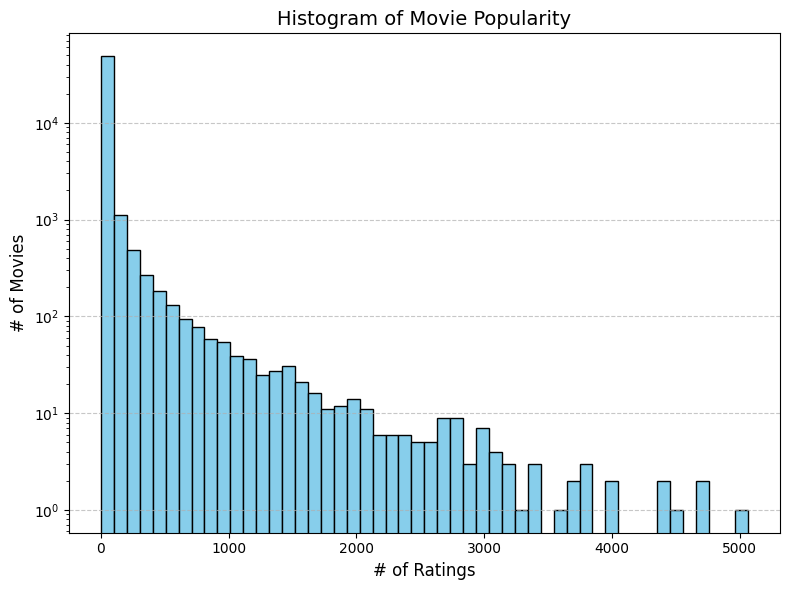

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of ratings per movie
ratings_per_movie = new_data['title'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(ratings_per_movie, bins=50, color='skyblue', edgecolor='black', log=True)

# Add labels and title
plt.title('Histogram of Movie Popularity', fontsize=14)
plt.xlabel('# of Ratings', fontsize=12)
plt.ylabel('# of Movies', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


**Exercise**: Plot the histogram of user activity (x-axis: # of given ratings, y-axis: # of users with the given # of ratings). Include the plot in your report.

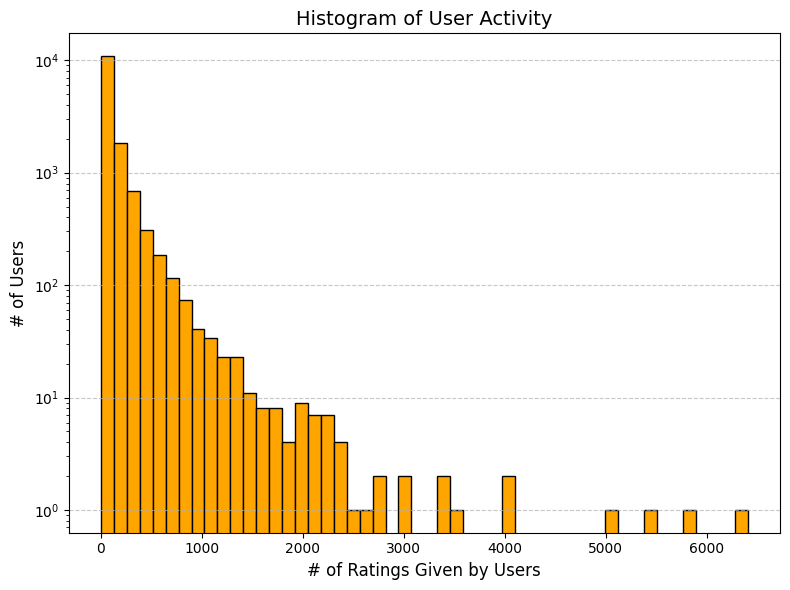

In [ ]:

# Calculate the number of ratings per user
ratings_per_user = new_data['userId'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(ratings_per_user, bins=50, color='orange', edgecolor='black', log=True)

# Add labels and title
plt.title('Histogram of User Activity', fontsize=14)
plt.xlabel('# of Ratings Given by Users', fontsize=12)
plt.ylabel('# of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Let's check the distribution of the movies.

Firstly, we need to check if all rows contain 'year' information:

In [ ]:

# Check if the title column contains a year in parentheses
new_data['has_year'] = new_data['title'].str.contains(r'\(\d{4}\)', regex=True)

# Identify titles missing the year
missing_year_titles = new_data[~new_data['has_year']]

# Output the result
if missing_year_titles.empty:
    print("All titles include a bracket containing year information.")
else:
    print("The following titles are missing year information:")
    print(missing_year_titles[['title']])


The following titles are missing year information:
                                  title
5348                       The Northman
5607      I'm Thinking of Ending Things
12295                      Enola Holmes
14904                          Paterson
14912     I'm Thinking of Ending Things
...                                 ...
31988999                   The Northman
31990208                       The King
31992142              Nocturnal Animals
31992149                      Moonlight
31997158                    Bones & All

[9916 rows x 1 columns]


Count how many movies are missing their 'year' information:

In [ ]:
# Step 1: Filter rows where the title is missing year information
missing_year_titles = new_data[~new_data['has_year']]

# Step 2: Count unique movies (titles) missing year information
unique_missing_titles_count = missing_year_titles['title'].nunique()

# Output the result
print(f"There are {unique_missing_titles_count} unique movies missing year information.")


There are 250 unique movies missing year information.


Considering that we have around 51k unique movies in this dataset, we can just ignore the missing information and generate a distribution plot of the rest movies.

 **Excercise:** Plot the histogram of movie years (x-axis: # year, y-axis: # of movies produed in that year). Include the plot in your report.

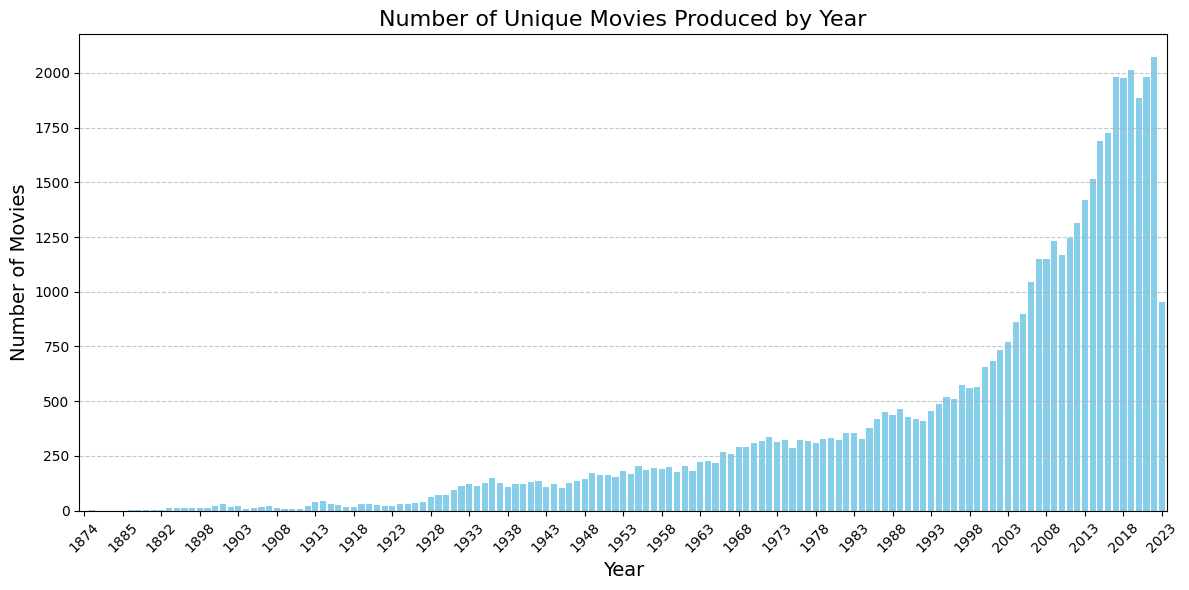

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter rows with valid year information
new_data_with_year = new_data[new_data['has_year']].copy()

# Step 2: Extract the year from the title column
new_data_with_year['year'] = new_data_with_year['title'].str.extract(r'\((\d{4})\)')

# Step 3: Remove duplicates based on the title column
unique_movies = new_data_with_year.drop_duplicates(subset='title')

# Step 4: Count the number of unique movies produced each year
movies_per_year = unique_movies['year'].value_counts().sort_index()

# Step 5: Plot the histogram of unique movies by year
plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='bar', width=0.8, color='skyblue')

# Set x-axis labels to display every 5 years
plt.title('Number of Unique Movies Produced by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(range(0, len(movies_per_year), 5), movies_per_year.index[::5], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Exercise**: Compute the average ratings for every movie and find the top 20 highly rated movies. Include the list of 20 highly rated movies and their ratings in your report.

In [ ]:

# Compute the average rating for each movie
movie_avg_ratings = new_data.groupby('title')['rating'].mean()

# Sort the movies by their average ratings in descending order
top_50_movies = movie_avg_ratings.sort_values(ascending=False).head(50)

# Print the results
print("Top 50 Highly Rated Movies:")
print(top_50_movies)


Top 50 Highly Rated Movies:
title
Life is to Whistle (Vida es silbar, La) (1998)           5.0
Classic Albums: The Doors - The Doors (2008)             5.0
The Godfather Family: A Look Inside (1990)               5.0
Classic Albums: Metallica - Metallica (2001)             5.0
Class (2010)                                             5.0
Suzy Snowflake (1951)                                    5.0
Ace of Hearts (2008)                                     5.0
Promise of Pisa (2019)                                   5.0
Clancy Once Again (2017)                                 5.0
Clancy (2009)                                            5.0
Civilisation (1969)                                      5.0
Civil Love (2012)                                        5.0
City of Your Final Destination, The (2009)               5.0
Susie's Hope (2013)                                      5.0
With Love, Christmas (2017)                              5.0
Autumn Stables (2018)                              

We see that some highly rated movies are not popular ones.

histogram of the movies(yesars)

---
## Train, Validation, and Test Data

Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [ ]:
#Split the data into train, validation and test
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(new_data, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

In [ ]:
user_id_train = ratings_train['userId']
item_id_train = ratings_train['movieId']
rating_train = ratings_train['rating']

user_id_test = ratings_test['userId']
item_id_test = ratings_test['movieId']
rating_test = ratings_test['rating']

In [ ]:
# Step 1: Identify movies not in the training set
movies_not_train = list(set(new_data['movieId']) - set(item_id_train))

# Step 2: Retrieve the names of these movies
movies_not_train_names = set(new_data.loc[new_data['movieId'].isin(movies_not_train), 'title'])

# Step 3: Print the movie names
print(movies_not_train_names)
print(len(movies_not_train_names))


{'Guest iin London (2017)', 'Deadliest Prey (2013)', 'Owned: A Tale of Two Americas (2018)', 'Secret (2011)', 'Sanam Teri Kasam (2016)', 'Calamity, a Childhood of Martha Jane Cannary (2020)', 'Fast and Loose (1930)', 'Ugly, The (1997)', "Elizabeth's Gift (2012)", 'Golden Door (Nuovomondo) (2006)', 'The Other Side (1994)', 'Foe (2023)', 'The Cannibals (1972)', "Midsummer Night's Dream, A (1968)", 'The Messenger (2019)', 'Some Call It Loving (1973)', 'Reborn (2018)', 'American Pain (2022)', 'Ginza Cosmetics (1951)', 'Hitler- Dead or Alive (1942)', 'Jo & Jo (2022)', 'True Identity (1991)', 'Go West (1940)', 'Viktoria (2014)', 'Cymbeline (2014)', 'A Perfect Plan (2020)', 'Beyond Desire (1995)', 'Miyamoto Musashi (1961)', 'Escape from Wildcat Canyon (1998)', 'Jimi Hendrix: Electric Ladyland (2008)', 'A Man Called Blade (1977)', 'Street with No Name, The (1948)', 'America, America (1963)', 'The 90 Day Plan (2021)', 'Canvas (2021)', "If It Don't Fit, Use a Bigger Hammer (2002)", 'Tom and Jerr

We see that a few movies are not rated in the train set. For those movies, it is hard to predict their ratings accurately.

---
## Data Load and Batching

Use GPU if available.

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We define a function to return a triplet of user_num, item_num, rating from the dataframe.

In [ ]:

def df_2_tensor(df, device):
    # Ensure correct column names are used
    user_num = np.asarray(df['user_num'])
    movie_num = np.asarray(df['movie_num'])
    rating = np.asarray(df['rating'])

    # Convert to PyTorch tensors and move to the specified device
    return (
        torch.from_numpy(user_num).to(device),
        torch.from_numpy(movie_num).to(device),
        torch.from_numpy(rating).to(device)
    )


Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [ ]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

We now do the same thing for the validation and test sets.

In [ ]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list (Hint: you may use the [zip function](https://www.w3schools.com/python/ref_func_zip.asp)); then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling.

**Exercise**: Filling in the missing code below to construct dataset and dataloader.

In [ ]:
def tensor_2_dataset(user,item,rating):
    # your code here
    # Hint: check the zip function
    return list(zip(user,item,rating))

def make_dataloader(dataset,bs,shuffle):
    # your code here
    return torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=shuffle)

In [ ]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

Load the train, validation, and test data in batchs of size 1024.

In [ ]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

---
## The model



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will use some custom embeddings defined as below.

In [ ]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

### Creating Our Own Embedding Module

Now, we define the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.







**Exercise**: Fill the missing code to define the embeddings.

In [ ]:
class DotModel(nn.Module):

    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):

        super(DotModel, self).__init__()

        self.embedding_dim = embedding_dim

        # TODO: generate user and item embeddigns using ScaledEmbedding
        # your code
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)

        # TODO: generate bias embeddigns using ZeroEmbedding
        # your code
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)


    def forward(self, user_ids, item_ids):
        #
        # your code
        #
        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        dot = torch.mul(user_embedding, item_embedding).sum(1)
        res = dot + user_bias + item_bias

        return res

Note that in the above code, we use [`torch.mul`](https://pytorch.org/docs/stable/generated/torch.mul.html), which performs an elementwise multiplication with broadcasting.

In [ ]:
net = DotModel(total_user_id,total_item_id).to(device)

In [ ]:
net

DotModel(
  (user_embeddings): ScaledEmbedding(14301, 32)
  (item_embeddings): ScaledEmbedding(51858, 32)
  (user_biases): ZeroEmbedding(14301, 1)
  (item_biases): ZeroEmbedding(51858, 1)
)

Now we check your network by taking  a batch from train loader.

In [ ]:
batch_user, batch_item, batch_rating = next(iter(train_dataloader))
batch_user, batch_item, batch_rating = batch_user.to(device), batch_item.to(device), batch_rating.to(device)

In [ ]:
predictions = net(batch_user, batch_item)
predictions.shape

torch.Size([1024])

We will use MSE loss defined below:

In [ ]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [ ]:
loss=regression_loss(predictions,batch_rating)

In [ ]:
loss

tensor(13.1639, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

## Train and test the model

Now we define `FactorizationModel` class  that allows us to train and evaluate the explicit factorization models.


- The `fit` function should take as argument a dataloader for the training and a dataloader for the validation. At the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

- Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

**Exercise**: Filling in the missing code below to complete the training pass and validation pass.

In [ ]:
class FactorizationModel(object):

    def __init__(self, embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):

        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()


    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)

        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2    #here we set weight decay to add the L2 regularization
            )

        self._loss_func = regression_loss

    @property
    def _initialized(self):
        return self._optimizer is not None


    def fit(self, dataloader, val_dataloader, verbose=True):
        if not self._initialized:
            self._initialize()

        valid_loss_min = np.Inf # track change in validation loss
        train_losses, valid_losses, valid_maes =[], [], []

        for epoch_num in range(self._n_iter):
            tot_train_loss = 0.0
            ###################
            # train the model #
            ###################
            #TODO: trainining loop:
            # your code
            self._net.train()
            for batch_user, batch_item, batch_rating in dataloader:

                bath_user=batch_user.to(device)
                batch_item=batch_item.to(device)
                batch_rating=batch_rating.to(device)

                #1. Compute the output
                predictions = self._net(batch_user,batch_item)
                #2. Compute the loss
                #loss = self._loss_func(predictions,batch_rating)
                loss = self._loss_func(predictions,batch_rating)
                # 3. Zero out the gradient
                self._optimizer.zero_grad()
                # 4. Backward pass, compute the new gradients
                loss.backward()
                # 5. Update the weights
                self._optimizer.step()

                tot_train_loss += loss.item()


            train_loss = tot_train_loss /len(dataloader)
            # Go to the validation loop
            valid_loss, valid_mae = self.test(val_dataloader)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_maes.append(valid_mae)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num, train_loss,valid_loss))

            if np.isnan(train_loss) or train_loss == 0.0:
                raise ValueError('Degenerate train loss: {}'.format(train_loss))

            #TODO: Saving model if validation loss has decreased
            if valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
              torch.save(self._net.state_dict(), 'model_cf.pt')
              valid_loss_min = valid_loss

        return train_losses, valid_losses, valid_maes


    ######################
    # validate/Test the model #
    ######################
    def test(self,dataloader, verbose = False):
        self._net.eval()
        L1loss = torch.nn.L1Loss()
        tot_test_loss = 0.0
        tot_test_mae = 0.0

        # TODO: validation/testing loop
        # your code here (mae = mean absolute error)
        with torch.no_grad():
          for batch_user, batch_item, batch_rating in dataloader:
            #1. compute the output
            predictions = self._net(batch_user,batch_item)
            #2. Compute the loss
            loss = self._loss_func(predictions,batch_rating)

            tot_test_loss += loss.item()
            tot_test_mae += L1loss(predictions,batch_rating.type(torch.FloatTensor).to(device))


        test_loss = tot_test_loss / len(dataloader)
        test_mae = tot_test_mae / len(dataloader)
        if verbose:
            print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}") # do not forget to take the square root to compute RMSE
        return test_loss, test_mae

In [ ]:
model = FactorizationModel(embedding_dim=50,  # latent dimensionality
                                   n_iter=30,  # number of epochs of training
                                   learning_rate=5e-4,
                                   l2=1e-8,  # strength of L2 regularization
                                   num_users=total_user_id,
                                   num_items=total_item_id)

In [ ]:
print(len(train_dataloader.dataset))  # Check dataset size
print(train_dataloader.batch_size)   # Check batch size


1382798
1024


In [ ]:
train_losses,valid_losses,valid_maes =model.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 8.679214197947875, loss_val 2.9369173384840694
Validation loss decreased (inf --> 2.936917).  Saving model ...
Epoch 1: loss_train 1.9239215242074148, loss_val 1.4571555615330969
Validation loss decreased (2.936917 --> 1.457156).  Saving model ...
Epoch 2: loss_train 1.1935024375007484, loss_val 1.115542720812899
Validation loss decreased (1.457156 --> 1.115543).  Saving model ...
Epoch 3: loss_train 0.9600432066654351, loss_val 0.9711875614708912
Validation loss decreased (1.115543 --> 0.971188).  Saving model ...
Epoch 4: loss_train 0.8452214660082383, loss_val 0.8931860444836667
Validation loss decreased (0.971188 --> 0.893186).  Saving model ...
Epoch 5: loss_train 0.7750042310147943, loss_val 0.8435734280705053
Validation loss decreased (0.893186 --> 0.843573).  Saving model ...
Epoch 6: loss_train 0.725452411850894, loss_val 0.808677300680995
Validation loss decreased (0.843573 --> 0.808677).  Saving model ...
Epoch 7: loss_train 0.6876573406209673, loss_val 0

**Exercise**: Let's plot the train losses and test losses over epoches.
At which epoch, you would stop the training? Include the plot and your answer in the report.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

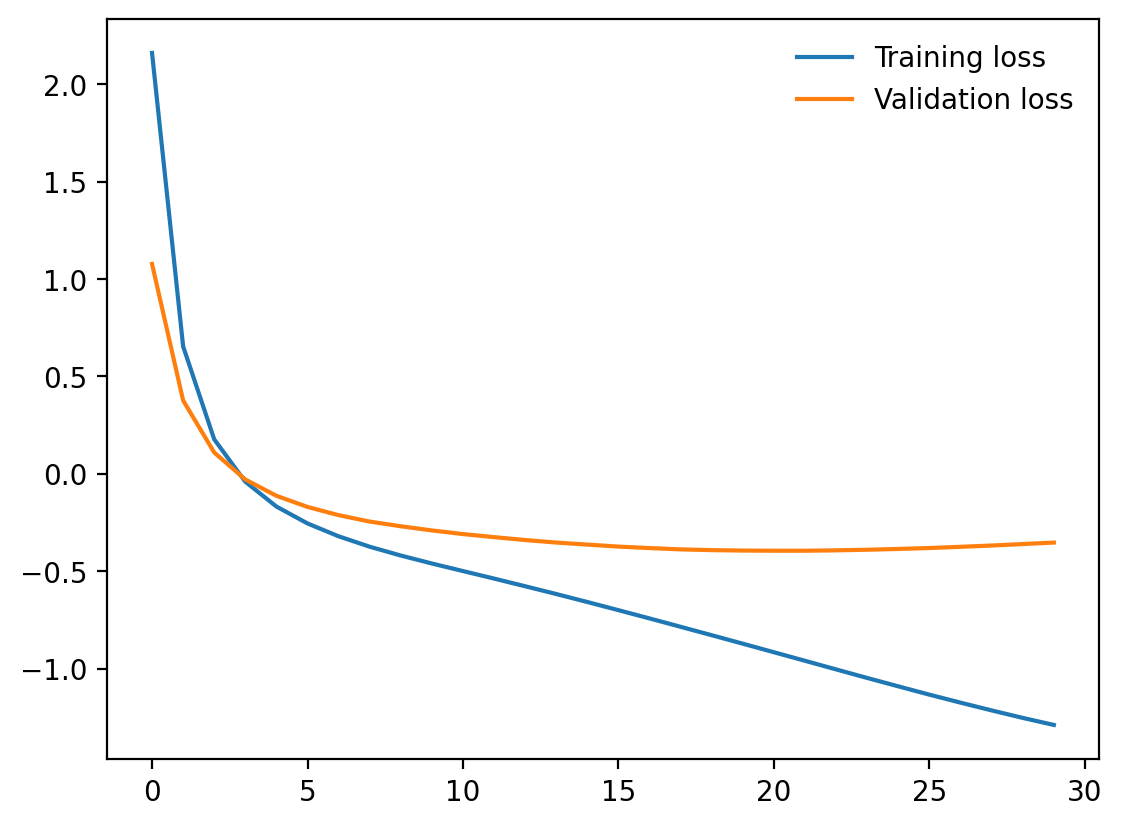

In [ ]:
plt.plot(np.log(train_losses), label='Training loss')
plt.plot(np.log(valid_losses), label='Validation loss')
plt.legend(frameon=False)

We see that around epoch 30, we achieve the lowest validation loss and hence we would stop training at epoch 28.

Now, let's compute the RMSE and mean absolute error on the test data.

In [ ]:
model._net.load_state_dict(torch.load('model_cf.pt'))

<ipython-input-57-030adbcfeb49>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model._net.load_state_dict(torch.load('model_cf.pt'))


<All keys matched successfully>

In [ ]:
test_loss, test_mae = model.test(test_dataloader,True)

RMSE: 0.8201374969290327, MAE: 0.5976987481117249


We see that our RMSE is around 0.85 and MAE is 0.67. Don't forget to take the square root to compute the RMSE (square root of the mean sequared error).

## Optimize your model and training

**Exercise**: Play with the hyperparameters (embedding_dim, n_iter, learning_rate, L2 regularization, etc) to beat the benchmarks presented in [Surprise](https://github.com/NicolasHug/Surprise). List the hyperparameters and the RMSE and MAE on test data in the report. Save the model state to `model_cf.pt` and submit it to Canvas.


In [ ]:
model_tuning = FactorizationModel(embedding_dim=128, # embedding_dim 50 --> 128
                  n_iter=30,
                  learning_rate=1e-4,
                  l2=5e-8,  # l2-penalty 1e-8 --> 5e-8
                  num_users=total_user_id,
                  num_items=total_item_id)

In [ ]:
train_losses,test_losses, test_maes = model_tuning.fit(train_dataloader,val_dataloader)

Epoch 0: loss_train 12.962988779059618, loss_val 11.377164593613923
Validation loss decreased (inf --> 11.377165).  Saving model ...
Epoch 1: loss_train 7.9717890525892985, loss_val 5.185196455184166
Validation loss decreased (11.377165 --> 5.185196).  Saving model ...
Epoch 2: loss_train 3.873051644027371, loss_val 3.0789205426250925
Validation loss decreased (5.185196 --> 3.078921).  Saving model ...
Epoch 3: loss_train 2.5550752433790223, loss_val 2.2613100753590643
Validation loss decreased (3.078921 --> 2.261310).  Saving model ...
Epoch 4: loss_train 1.9429427327952713, loss_val 1.8177401817533283
Validation loss decreased (2.261310 --> 1.817740).  Saving model ...
Epoch 5: loss_train 1.5903051403386839, loss_val 1.546586784540084
Validation loss decreased (1.817740 --> 1.546587).  Saving model ...
Epoch 6: loss_train 1.3668696632508246, loss_val 1.3683032822147856
Validation loss decreased (1.546587 --> 1.368303).  Saving model ...
Epoch 7: loss_train 1.216101118892374, loss_val

In [ ]:
model_tuning._net.load_state_dict(torch.load('model_cf.pt'))


<ipython-input-61-ed794d39d124>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_tuning._net.load_state_dict(torch.load('model_cf.pt'))


<All keys matched successfully>

In [ ]:
test_loss, test_mae = model_tuning.test(test_dataloader,verbose=True)

RMSE: 0.8843553150057182, MAE: 0.6461578607559204


Here is comparison between the best benckmarks in [Surprise](https://github.com/NicolasHug/Surprise) and our model after hyperparameters tunning.

| [Movielens 1M](https://grouplens.org/datasets/movielens/1m)                                                                             |   RMSE |   MAE |
|:----------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|
| [SVD++ (cache_ratings=False)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| [SVD++ (cache_ratings=True)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| **Ours**|  **0.850** | **0.666** |


Our model beats their best ones！

## Well Done!

<img src="https://video.udacity-data.com/topher/2018/November/5be21b06_dancing-beemo/dancing-beemo.gif?raw=true" width=40%>

## Interpreting Biases

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

**Exercise**: What are your top 10 movies with the largest values of movie bias? What do you think about this ranking? Include your answers in your report.

In [ ]:
#TODO: retreive the bias of the movies from your optimized model and store it in the numpy array item_bais_np
item_bias_np = model_tuning._net.item_biases.weight.data.cpu().numpy()
item_bias_np = item_bias_np.squeeze()

In [ ]:
numitem_2_name = {i: name for name, i in np.asarray(new_data[['title', 'movie_num']])}
name_2_numitem = {name: i for name, i in np.asarray(new_data[['title', 'movie_num']])}


In [ ]:
list_name_bias = [[name, item_bias_np[name_2_numitem[name]]] for name in list(ratings_train['title'].unique())]


In [ ]:
# Sort movies by bias and get top 10
list_name_bias.sort(key=lambda x: x[1])  # Sort by bias score
top_10_bias_movies = list_name_bias[-10:]  # Get top 10 movies with the largest bias

# Print movie names and their bias
print("Top 10 Movies with the Largest Bias:")
for movie, bias in top_10_bias_movies:
    print(f"Movie: {movie}, Bias: {bias:.8f}")


Top 10 Movies with the Largest Bias:
Movie: Pulp Fiction (1994), Bias: 0.37069875
Movie: Fight Club (1999), Bias: 0.37292409
Movie: Interstellar (2014), Bias: 0.37546173
Movie: Inception (2010), Bias: 0.37734151
Movie: Spider-Man: No Way Home (2021), Bias: 0.38636249
Movie: Shawshank Redemption, The (1994), Bias: 0.40563515
Movie: Top Gun: Maverick (2022), Bias: 0.41073349
Movie: Everything Everywhere All at Once (2022), Bias: 0.47709009
Movie: Parasite (2019), Bias: 0.47768372
Movie: Dune (2021), Bias: 0.58526605


In [ ]:
# Assuming new_data contains the dataset with title and genres columns
top_10_titles = [movie[0] for movie in top_10_bias_movies]  # Extract top 10 movie titles

# Find genres for the top 10 movies
print("\nTop 10 Movies and Their Genres:")
for title in top_10_titles:
    # Search for the movie title in the dataset
    genre = new_data[new_data['title'] == title]['genres'].values
    if len(genre) > 0:
        print(f"Movie: {title}, Genre: {genre[0]}")
    else:
        print(f"Movie: {title}, Genre: Not Found")



Top 10 Movies and Their Genres:
Movie: Pulp Fiction (1994), Genre: Comedy|Crime|Drama|Thriller
Movie: Fight Club (1999), Genre: Action|Crime|Drama|Thriller
Movie: Interstellar (2014), Genre: Sci-Fi|IMAX
Movie: Inception (2010), Genre: Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
Movie: Spider-Man: No Way Home (2021), Genre: Action|Adventure|Fantasy|Sci-Fi
Movie: Shawshank Redemption, The (1994), Genre: Crime|Drama
Movie: Top Gun: Maverick (2022), Genre: Action|Drama
Movie: Everything Everywhere All at Once (2022), Genre: Action|Comedy|Sci-Fi
Movie: Parasite (2019), Genre: Comedy|Drama
Movie: Dune (2021), Genre: Action|Adventure|Drama|Sci-Fi


**What Does This Mean for Your Recommendation System?**

1.Bias Toward Popular Movies:

The system seems to favor critically acclaimed, highly rated, and popular movies. This might lead to over-recommendation of these movies, reducing exposure to lesser-known titles.

2.Genre Influence:

Action, Drama, and Sci-Fi are heavily represented, suggesting that the system might give disproportionate importance to these genres.

**Potential Issues:**

1.Lack of Diversity:
Users who prefer niche genres might not see their interests adequately represented.
Recency Bias:
Newer movies like Spider-Man: No Way Home and Top Gun: Maverick might be overly favored due to recent activity or popularity.

2.Recommendation System Behavior: The system could be overfitting to the preferences of a large, mainstream audience, leading to biased results that may not cater well to unique or minority user preferences.


---
## Movie valuation

The rating data provided the company like Netflix information about the value of a movie that was not available to movie production studios. The collaborative filting algorithm allows Netflix to accurately value the content in a data-driven manner. For example, if Netflix were offered the opportunity to license *Toy Story (1995)*, it would need to provide Disney an initial quote of the license fee. Traditional methods suggest looking at box office returns of *Toy Story* franchise and projecting the potential value of the film.

In this following, we will explore a novel approach to determine the valuation of a movie based on the predicted ratings. We make the following simplifying assumpitons (Note that these assumptions can be certainly relaxed with more complicated procedures and data):

- **Netflix are focusing on the top 1000 active users and 1000 popular movies (with the most number of observed ratings).** In other words, in the following movie valuation calculation, we just consider the top 1000 activie users and 1000 popular movies, disregarding the rest.

- For each user, the total amount of viewing time is proportional to the number of observed ratings. In other words, more active users spend more time on Netflix;

- For each given user, the viewing time across different movies follow a [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), that is

  $$
    \text{Viewtime of movie $i$} \propto \frac{1}{\text{rank of } i }
  $$

  Here the rank of $i$ is determined by sorting the **predicted rating** of movie $i$ by the user in descending order. In other words, the user spend less time on watching movies with lower ratings.

- Netflix has a fixed total budget of 1 Billion dollars to license the content;

- Netflix estimates the value of a movie based on the expected share of customer viewing time of the movie on its platform:

$$
\text{Value of a movie $i$ } = \frac{\text{View time of movie $i$ of all users}}{\text{Total view time of all users} } \times \text{Total content license budget}
$$


### Compute the value of each movie

In [ ]:
# Get indices for top 1000 active users and top 1000 mostly rated movies
top1000_user_num = pd.Series(new_data["user_num"].value_counts()[:1000].index, name="user_num")
top1000_item_num = pd.Series(new_data["movie_num"].value_counts()[:1000].index, name="movie_num")
# Construct dataframes for storing predicted ratings
pred_ratings = pd.merge(top1000_user_num, top1000_item_num, how="cross")
cartesian_user_num = torch.from_numpy(np.asarray(pred_ratings["user_num"])).to(device)
cartesian_item_num = torch.from_numpy(np.asarray(pred_ratings["movie_num"])).to(device)

In [ ]:
pred_ratings.head()

,user_num,movie_num
0,978,12859
1,978,10727
2,978,2151
3,978,16894
4,978,283


In [ ]:
# sanity check: # of rows in pred_ratings == # of active users (1000) x # of popular items (1000)
pred_ratings.shape[0] == 1000 * 1000

True

In [ ]:
#TODO: use your optimized model to compute the predicted ratings among the top 1000 active users and top 1000 popular movies
# model_tuning._net predictions over cartesian_user_num and cartesian_item_num
model_tuning._net.eval()
pred_ratings["pred_ratings"] = model_tuning._net(cartesian_user_num, cartesian_item_num).cpu().detach().numpy()

In [ ]:
# Each user's total viewtime is stored in Series user_total_viewtime
user_total_viewtime = new_data["user_num"].value_counts()[:1000] /new_data["user_num"].value_counts()[:1000].sum()
user_total_viewtime.name = "user_total_viewtime"
user_total_viewtime.index.name = "user_num"
pred_ratings = pd.merge(pred_ratings, user_total_viewtime, left_on="user_num", right_on="user_num", how="left")

In [ ]:
pred_ratings.head()

,user_num,movie_num,pred_ratings,user_total_viewtime
0,978,12859,2.616462,0.008787
1,978,10727,2.641433,0.008787
2,978,2151,3.085245,0.008787
3,978,16894,2.479954,0.008787
4,978,283,2.870272,0.008787


In [ ]:
# Each user per each movie viewtime: pred_all_ratings["user_item_viewtime"] = ["1/user_rank"] / ["sum(1/user_rank)"] * ["user_total_viewtime"]
# these wordy codes are to reduce RAM consumption otherwise Colab may crush
pred_ratings["1/user_rank"] = 1/pred_ratings.groupby("user_num")["pred_ratings"].rank(method = "min", ascending = False)
sum_inverse_user_rank = pred_ratings.groupby("user_num")["1/user_rank"].sum()
sum_inverse_user_rank.name = "sum(1/user_rank)"
pred_ratings = pd.merge(pred_ratings, sum_inverse_user_rank, left_on="user_num", right_on="user_num", how="left")
pred_ratings["user_item_viewtime"] = pred_ratings["1/user_rank"] / pred_ratings["sum(1/user_rank)"] * pred_ratings["user_total_viewtime"]

In [ ]:
pred_ratings

,user_num,movie_num,pred_ratings,user_total_viewtime,1/user_rank,sum(1/user_rank),user_item_viewtime
0,978,12859,2.616462,0.008787,0.002519,7.485471,2.956916e-06
1,978,10727,2.641433,0.008787,0.002695,7.485471,3.164139e-06
2,978,2151,3.085245,0.008787,0.019231,7.485471,2.257491e-05
3,978,16894,2.479954,0.008787,0.001883,7.485471,2.210726e-06
4,978,283,2.870272,0.008787,0.005747,7.485471,6.746526e-06
...,...,...,...,...,...,...,...
999995,8906,1120,3.455472,0.000483,0.001449,7.485471,9.346915e-08
999996,8906,10422,3.817162,0.000483,0.011111,7.485471,7.165968e-07
999997,8906,35072,3.169242,0.000483,0.001073,7.485471,6.919926e-08
999998,8906,7221,3.559966,0.000483,0.001969,7.485471,1.269561e-07


In [ ]:
# sanity check: sum of user_item_viewtime == 1
pred_ratings["user_item_viewtime"].sum()

1.0000000000000004

In [ ]:
# compute each movie's value
budget =  1000000000
#TODO: compute the values of movies based on pred_ratings
movie_values = pred_ratings.groupby("movie_num")["user_item_viewtime"].sum() * budget
movie_values.name = "item_value"

In [ ]:
# replace item_num by item_name
movie_values = movie_values.to_frame()
movie_values["title"] = [numitem_2_name[movie_num] for movie_num in movie_values.index]
movie_values = movie_values.set_index("title").squeeze(axis=1)

In [ ]:
movie_values.head()

,item_value
title,
Toy Story (1995),4.315947e+05
Jumanji (1995),2.066389e+05
Heat (1995),1.287237e+06
GoldenEye (1995),1.955775e+05
Casino (1995),2.200665e+06


In [ ]:
# sanity check: sum of movie values == budget
movie_values.sum() == budget

True

### Output the top valued movies

In [ ]:
movie_values.nlargest(30)

,item_value
title,
Band of Brothers (2001),1.064791e+08
12 Angry Men (1957),6.461979e+07
Twelve Angry Men (1954),4.865002e+07
Parasite (2019),2.610738e+07
"Thing, The (1982)",2.024232e+07
Whiplash (2013),1.986459e+07
Pulp Fiction (1994),1.636190e+07
Spider-Man: Across the Spider-Verse (2023),1.290604e+07
Princess Mononoke (Mononoke-hime) (1997),1.278782e+07


**Question**: Include your answer in the report.

- What is your estimated value of *Toy Story (1995)*?

- What are the top 10 mostly valued movies?


In [ ]:
movie_values['Toy Story (1995)']

431594.70326415665

 The top 10 mostly valued movies are




1. Band of Brothers (2001)               92,666,750

2. 12 Angry Men (1957)                  51,854,580

3. Twelve Angry Men (1954)          48,828,610

4. Parasite (2019)                  29,259,560
5. Pulp Fiction (1994)              27,112,650
6. Whiplash (2013)                  15,935,770
7. Princess Mononoke (Mononoke-hime) (1997)  13,633,740
8. Shawshank Redemption, The (1994) 11,897,290
9. Godfather, The (1972)            11,278,340
10.No Country for Old Men (2007)    10,786,350



### Compare the output with the mostly rated movies. Identify the discrepancies.

In [ ]:
highest_values_30 = movie_values.nlargest(30).index
most_rated_30 = new_data['title'].value_counts().nlargest(30).index

In [ ]:
# movies IN top 30 valued AND IN most 30 rated
set(highest_values_30).intersection(set(most_rated_30))

{'Parasite (2019)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)'}

In [ ]:
# movies IN top 30 valued but NOT in most 30 rated
set(highest_values_30) - set(most_rated_30)

{'12 Angry Men (1957)',
 '2001: A Space Odyssey (1968)',
 'Alien (1979)',
 'Apocalypse Now (1979)',
 'Band of Brothers (2001)',
 'Downfall (Untergang, Der) (2004)',
 'Firefly (2002)',
 'Ghost in the Shell (Kôkaku kidôtai) (1995)',
 'Godfather: Part II, The (1974)',
 'Goodfellas (1990)',
 'Grave of the Fireflies (Hotaru no haka) (1988)',
 'In the Mood For Love (Fa yeung nin wa) (2000)',
 "It's a Wonderful Life (1946)",
 'Lives of Others, The (Das leben der Anderen) (2006)',
 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)',
 "Once Upon a Time in the West (C'era una volta il West) (1968)",
 'Perfect Blue (1997)',
 'Princess Mononoke (Mononoke-hime) (1997)',
 'Rear Window (1954)',
 'Seven Samurai (Shichinin no samurai) (1954)',
 'Spider-Man: Across the Spider-Verse (2023)',
 'Sting, The (1973)',
 'There Will Be Blood (2007)',
 'Thing, The (1982)',
 'Twelve Angry Men (1954)',
 'Whiplash (2013)',
 'Your Name. (2016)'}

In [ ]:
# movies IN most 30 rated but NOT IN top 30 valued
set(most_rated_30) - set(highest_values_30)

{'Arrival (2016)',
 'Dark Knight, The (2008)',
 'Django Unchained (2012)',
 'Dune (2021)',
 'Everything Everywhere All at Once (2022)',
 'Fight Club (1999)',
 'Forrest Gump (1994)',
 'Godfather, The (1972)',
 'Inception (2010)',
 'Inglourious Basterds (2009)',
 'Interstellar (2014)',
 'Knives Out (2019)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Matrix, The (1999)',
 'Shutter Island (2010)',
 'Spider-Man: No Way Home (2021)',
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'The Batman (2022)',
 'The Martian (2015)',
 'Top Gun: Maverick (2022)',
 'Up (2009)',
 'WALL·E (2008)',
 'Wolf of Wall Street, The (2013)'}

**Question**: Include your answers in your report.

- What are the movies that are top 30 rated but not in top 30 valued?
- What do you think about this approach of movie valuation? How does it compare with the approach based on the popularity of the movies?




**Answer**

The movies that are top 30 rated but not in top 30 valued are



*   'Arrival (2016)',
*   'Django Unchained (2012)',
*   'Dune (2021)'，
*   'Everything Everywhere All at Once (2022)',
*   'Fight Club (1999)',
*  'Forrest Gump (1994)',
*   'Inception (2010)',
*   'Inglourious Basterds (2009)',
*   'Interstellar (2014)',
*   'Knives Out (2019)',
*   
'Lord of the Rings: The Fellowship of the Ring, The (2001)',
*   'Lord of the Rings: The Return of the King, The (2003)',
*   'Lord of the Rings: The Two Towers, The (2002)',
'Matrix, The (1999)',
*   'Shutter Island (2010)',
*   'Spirited Away (Sen to Chihiro no kamikakushi) (2001)',
*   'Star Wars: Episode IV – A New Hope (1977)',
*  'Star Wars: Episode V – The Empire Strikes Back (1980)',
*   'The Batman (2022)',
*  'The Martian (2015)',
*   
'Top Gun: Maverick (2022)',
*   
'Up (2009)',
*  'WALL·E (2008)',
*  
'Wolf of Wall Street, The (2013)'






The above movie valuation approach takes into account both the popularity of the movies and the ratings of the movies. We see that some movies are very poular, but does not have a high rating.
However, we should not take the above movie valuation for granted. It definitely has many issues, for example, does not take into account how recent the movies are made. In practice Netflix has much rich data about user view time, so it can produce much better movie valuation. Nevertheless,  through this simple analysis, we can see how the recommender systems provides a promising, new way for content valuation.

In [ ]:
pred_ratings.groupby("item_num")['pred_ratings'].mean()[name_2_numitem['Toy Story (1995)']]

KeyError: 'item_num'

In [ ]:
all_ratings['item_name'].value_counts()['Toy Story (1995)']

In [ ]:
all_ratings['item_name'].value_counts()['Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)']

In [ ]:
pred_ratings.groupby("item_num")['pred_ratings'].mean()[name_2_numitem['Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)']]